## Just a quick test to try out how inversions of canopy reflectance would work in Julia

In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");

In [2]:
using FluspectMod
# import Pkg; Pkg.add("Optim")
using Optim
using Plots
using NCDatasets
using Statistics

┌ Info: Recompiling stale cache file /Users/cfranken/.julia/compiled/v1.1/FluspectMod.ji for FluspectMod [top-level]
└ @ Base loading.jl:1184


In [20]:
ds = Dataset("/Users/cfranken/Downloads/spectra_400-900.h5")
wl2 = ds["wl"][:];
refl = ds["refl"][:];
doy = ds["doy"][:];
wl = collect(399.5:1:899.51)
size(wl)
mean(FluspectMod.lambda)
#size(refl)

649.5

In [4]:
FluspectMod.init(wl)
# Define pseudo-truth x
x = [1.4;  80.0;  20.0;  0.0 ; 0.0;  0.009 ; 0.012;  0.;  3];
y = FluspectMod.RTM_sail(x)[:,1]
println(size(y))

(500,)


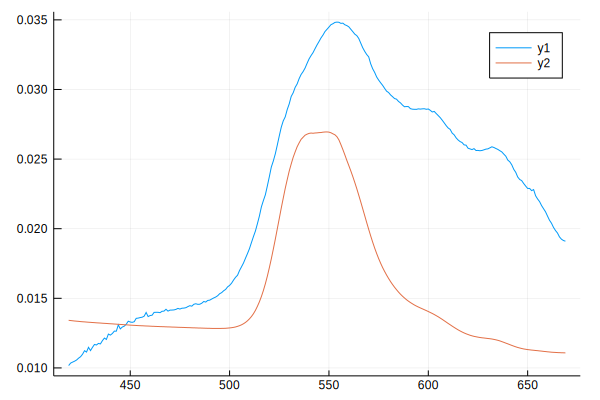

In [5]:

plot(wl2[20:270], refl[20:270,10])
plot!(wl2[20:270], y[20:270])

In [6]:
# Define start state vector, lower and upper bound:
# In order: N,Cab,Car,Ant,Cbrown,Cw,Cm,Cx,LAI
x0 = [1.1;  30.0;  10.0;  0.001 ; 0.001;  0.005 ; 0.02;  0.001;  3.8;0;0];
lower = [0.6; 0;0;0;0;0;0;0;3;-5;-1;];
upper = [3.0; 120;70;0.2;0.2;0.2;0.2;0.2;6;1;1;];

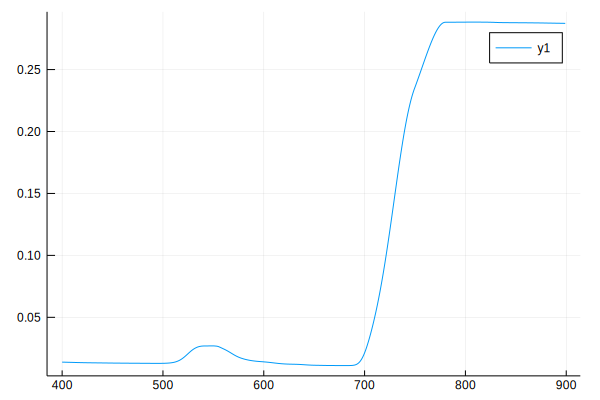

In [7]:
plot(FluspectMod.lambda,y)

In [8]:
# Define objective function (using L1 norm)
function g(x)
    R = FluspectMod.RTM_sail(x)
    return sum(abs.(R[50:270,1].-refl[50:270,10]))
end

g (generic function with 1 method)

In [15]:
# Minimize Function g(x)
results = optimize(g, lower, upper, x0,autodiff = :forward)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [1.1,30.0, ...]
 * Minimizer: [1.1264224373854994,9.837216934168776, ...]
 * Minimum: 9.646977e-02
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 8.29e-02 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3555
 * Gradient Calls: 3555

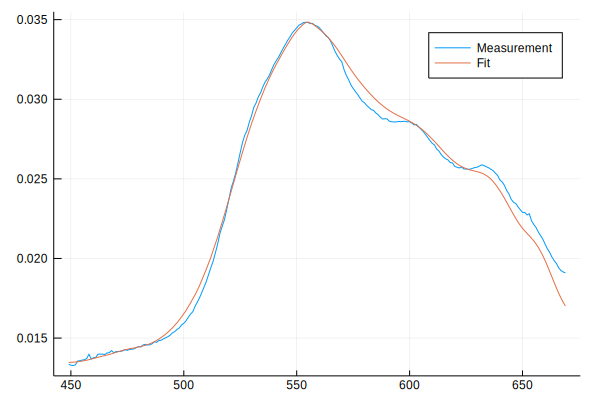

In [16]:
# Compute best fit again
RR = FluspectMod.RTM_sail(results.minimizer)
y0 = FluspectMod.RTM_sail(x0)
plot(FluspectMod.lambda[50:270],refl[50:270,10], label="Measurement")
plot!(FluspectMod.lambda[50:270],RR[50:270,1], label="Fit")
#plot!(FluspectMod.lambda,y0[:,1], label="Prior R")

In [21]:
Cab  = Float32[]
Ccar = Float32[]
lai = Float32[]
days = Float32[]

0-element Array{Float32,1}

In [29]:
for iR=1:254
    println(iR)
    # Define objective function (using L1 norm)
    function g(x)
        R = FluspectMod.RTM_sail(x)
        return sum(abs.(R[50:270,1].-refl[50:270,iR]))
    end
    # Minimize Function g(x)
    try
        results = optimize(g, lower, upper, x0)
        push!(Cab, results.minimizer[2])
        push!(Ccar, results.minimizer[3])
        push!(lai, results.minimizer[9])
        push!(days, doy[iR])
    catch
        println("Error")
    end
end

1
Error
2
3
4
5
6
7
8
9
Error
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254


In [30]:
Cab

265-element Array{Float32,1}:
 23.984453
 23.984453
 27.74044 
 21.871088
 20.98134 
 23.984453
 27.74044 
 21.871088
 20.98134 
 29.885872
 20.689837
 21.189348
 23.20241 
  ⋮       
 24.380608
 22.964455
 29.256456
 22.627441
 23.254845
 21.604647
 25.701338
 29.469908
 24.396784
 27.585506
 24.238907
 29.892992

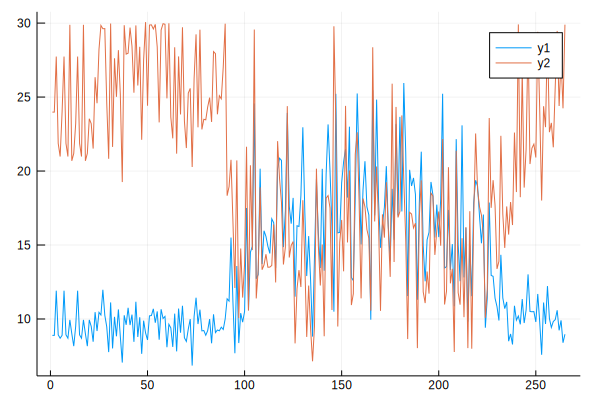

In [37]:
plot(Ccar)
plot!(Cab)

In [34]:
doy = ds["doy"][:];

In [35]:
plot(doy,Ccar)

BoundsError: BoundsError: attempt to access 254-element Array{Float64,1} at index [1:265]